<a href="https://colab.research.google.com/github/Shadoww002/PyTorch-Learning/blob/main/Chapter%202%20%E2%80%93%20Neural%20Network%20Classification/Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [322]:
## Import the Libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

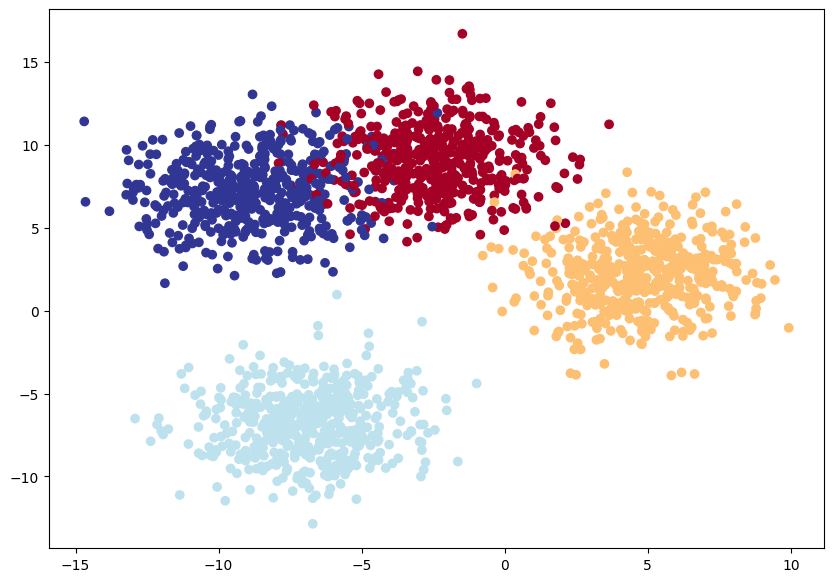

In [323]:
## Create Data and Data Splits
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob , y_blob = make_blobs(n_features=NUM_FEATURES,
                             n_samples=2000,
                             centers=NUM_CLASSES,
                             cluster_std = 2,
                             random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train , X_test , y_train , y_test = train_test_split(X_blob,
                                                       y_blob,
                                                       test_size=0.2,
                                                       random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0] , X_blob[:,1] , c = y_blob, cmap=plt.cm.RdYlBu  )



In [324]:
torch.cuda.is_available()

True

In [325]:
## Setting the davice
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [326]:
## Building the Model
class BlobModel(nn.Module):
  def __init__(self,input_featurs , output_features ,hidden_units):
    super().__init__()

    self.Linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_featurs , out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units , out_features=output_features )
    )


  def forward(self , x : torch.Tensor) -> torch.Tensor:
    return self.Linear_layer_stack(x)

model_1 = BlobModel(input_featurs=2,
                    output_features=4,
                    hidden_units=16).to(device)

model_1

BlobModel(
  (Linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [327]:
##Loss and OPtm function
loss_fn = nn.CrossEntropyLoss()
optm_fn = torch.optim.Adam(params=model_1.parameters(),
                          lr = 0.1)

In [328]:
model_1.eval()
with torch.inference_mode():
 y_logits = model_1(X_test.to(device))
y_logits[:10]

tensor([[-0.3013, -0.1437, -0.5177, -0.0950],
        [-0.3969, -0.2611, -0.8329, -0.3804],
        [-0.2037, -0.4289, -0.7715, -0.9667],
        [-0.3028, -0.2693, -0.9026, -0.3160],
        [-0.2128, -0.3363, -0.6710, -0.8614],
        [-0.1902, -0.3416, -0.7152, -0.8381],
        [-0.0946,  0.2860, -0.0667, -0.1212],
        [-0.2022,  0.2519,  0.1222, -0.1980],
        [-0.1967, -0.3869, -0.7424, -0.9078],
        [-0.1530, -0.0949, -0.6288, -0.3535]], device='cuda:0')

In [329]:
y_pred_prob= torch.softmax(y_logits ,dim=1)
y_pred_prob[:10]

tensor([[0.2378, 0.2784, 0.1915, 0.2923],
        [0.2626, 0.3008, 0.1698, 0.2669],
        [0.3532, 0.2820, 0.2002, 0.1647],
        [0.2801, 0.2897, 0.1538, 0.2764],
        [0.3290, 0.2908, 0.2081, 0.1720],
        [0.3362, 0.2890, 0.1989, 0.1759],
        [0.2240, 0.3277, 0.2303, 0.2181],
        [0.2015, 0.3174, 0.2788, 0.2024],
        [0.3451, 0.2854, 0.2000, 0.1695],
        [0.2858, 0.3029, 0.1776, 0.2338]], device='cuda:0')

In [330]:
y_pred = torch.argmax(y_pred_prob , dim=1)
y_pred[:10]

tensor([3, 1, 0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')

In [331]:
y_test[:10]

tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0])

In [332]:
## Calculating the Accuracy
def accuracy_fn(y_true ,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [333]:
##Train and Test LOOP
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train , X_test = X_train.to(device) , X_test.to(device)
y_train , y_test = y_train.to(device) , y_test.to(device)

epochs = 500

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits , dim=1).argmax(dim=1)
  # print(y_pred)

  loss = loss_fn(y_logits , y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  optm_fn.zero_grad()

  loss.backward()

  optm_fn.step()

  ## test

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)
    test_pred =torch.softmax(test_logits , dim=1 ).argmax(dim=1)

    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred= test_pred)

  if epoch % 50 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.4f} | Acc: {acc}% | Test_Loss = {test_loss} | test_Acc : {test_acc}%")


Epoch : 0 | Loss : 1.5353 | Acc: 6.6875% | Test_Loss = 0.6749404668807983 | test_Acc : 79.5%
Epoch : 50 | Loss : 0.0766 | Acc: 97.25% | Test_Loss = 0.0628838986158371 | test_Acc : 97.25%
Epoch : 100 | Loss : 0.0743 | Acc: 97.375% | Test_Loss = 0.06838344782590866 | test_Acc : 97.5%
Epoch : 150 | Loss : 0.0727 | Acc: 97.375% | Test_Loss = 0.06383226066827774 | test_Acc : 97.5%
Epoch : 200 | Loss : 0.0711 | Acc: 97.4375% | Test_Loss = 0.06473452597856522 | test_Acc : 97.75%
Epoch : 250 | Loss : 0.0711 | Acc: 97.375% | Test_Loss = 0.06658823788166046 | test_Acc : 97.5%
Epoch : 300 | Loss : 0.0706 | Acc: 97.375% | Test_Loss = 0.0698123350739479 | test_Acc : 97.75%
Epoch : 350 | Loss : 0.0762 | Acc: 97.125% | Test_Loss = 0.06335026025772095 | test_Acc : 97.0%
Epoch : 400 | Loss : 0.0740 | Acc: 97.0625% | Test_Loss = 0.07022497802972794 | test_Acc : 97.75%
Epoch : 450 | Loss : 0.0723 | Acc: 97.375% | Test_Loss = 0.06853332370519638 | test_Acc : 98.0%


In [334]:
model_1.eval()
with torch.inference_mode():
  y_pred_prob= torch.softmax(model_1(X_test),dim=1)
y_pred = torch.argmax(y_pred_prob , dim=1)
y_pred[:10]

tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0], device='cuda:0')

In [335]:
y_test[:10]

tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0], device='cuda:0')

In [336]:
## Using the helper Function From a repo
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


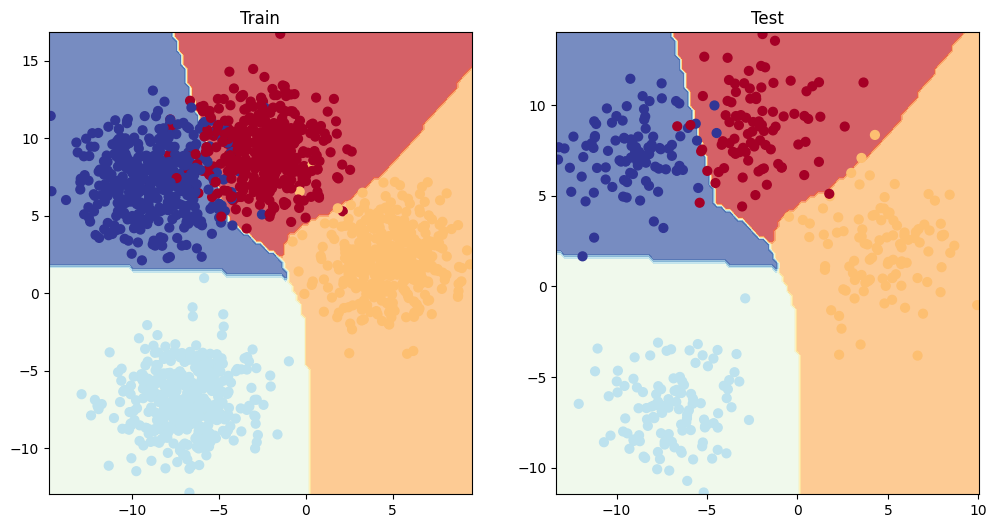

In [337]:
##  Visualising the Predictions
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,
                       X_train,
                       y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)